<a href="https://colab.research.google.com/github/Sherlock-221BBS/swin_transformer/blob/main/swin_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 30.45 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224
BATCH_SIZE = 32

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
   batch_size = BATCH_SIZE
)

(-0.5, 223.5, 223.5, -0.5)

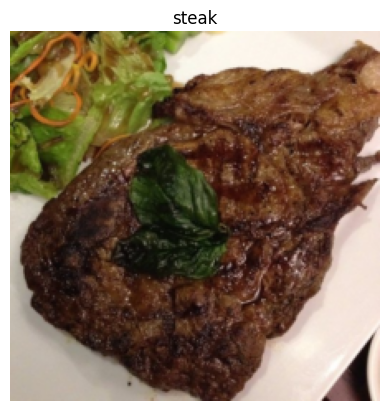

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[10], label_batch[10]

import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off')


In [9]:
from torch import nn, einsum
import numpy as np
import matplotlib.pyplot as plt
try:
  from einops import rearrange
except:
  print("[INFO] couldn't find einops, installing it")
  !pip install einops
  from einops import rearrange

[INFO] couldn't find einops, installing it
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 837.0 kB/s eta 0:00:00


In [10]:

class CyclicShift(nn.Module):
  def __init__(self, displacement):
    super().__init__()
    self.displacement = displacement
  def forward(self, x):
    x = torch.roll(input = x, shifts = (self.displacement, self.displacement), dims = (1, 2))
    return x

class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.fn = fn
    self.layer_norm = nn.LayerNorm(dim)

  def forward(self, x, **kwargs):
    x = self.fn(self.layer_norm(x), **kwargs)
    return x

class Residual(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, **kwargs):
    return self.fn(x, **kwargs)

class PatchMerging(nn.Module):
  def __init__(self, in_channels, out_channels, downscaling_factor):
    super().__init__()
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = out_channels,
                             kernel_size =downscaling_factor,
                             stride = downscaling_factor,
                             padding = 0)

  def forward(self, x):
    return self.patcher(x).permute(0, 2, 3, 1)

def create_mask(displacement, window_size, upper_lower, left_right):
  mask = torch.zeros(window_size ** 2, window_size ** 2)
  if upper_lower:
    mask[-displacement * window_size:, : -displacement * window_size] = float('-inf')
    mask[: -displacement * window_size, -displacement * window_size] = float('-inf')

  if left_right:
    mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1 = window_size, h2 = window_size)
    mask[:, -displacement:, :, :-displacement ] = float('-inf')
    mask[:, :-displacement,:, -displacement] = float('-inf')
    mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

  return mask

def get_relative_distances(window_size):
  indices = torch.tensor(np.array([[x,y] for x in range(window_size) for y in range(window_size)]))
  distances = indices[None, :, :] - indices[:, None, :]
  return distances


class WindowAttention(nn.Module):
  def __init__(self, dim, head_dim, heads, shifted, window_size, relative_position_embedding ):
    super().__init__()
    self.heads = heads
    self.scale = head_dim ** -0.5
    self.shifted = shifted
    self.window_size = window_size
    self.relative_position_embedding = relative_position_embedding

    if self.shifted:
      displacement = window_size // 2
      self.cyclic_shift = CyclicShift(-displacement)
      self.cyclic_shift_back = CyclicShift(displacement)
      self.upper_lower_mask = nn.Parameter(create_mask(displacement,
                                                       window_size = window_size,
                                                       upper_lower = True,
                                                       left_right = False), requires_grad = False)
      self.left_right_mask = nn.Parameter(create_mask(displacement,
                                                      window_size = window_size,
                                                      upper_lower = False,
                                                      left_right = True), requires_grad = False)

    if self.relative_position_embedding:
      self.relative_indices = get_relative_distances(window_size) + window_size - 1
      self.pos_embedding = nn.Parameter(torch.randn( 2 * window_size - 1, 2 * window_size -1), requires_grad = True)
    else:
      self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))
    self.to_qkv = nn.Linear(dim, dim * 3, bias = False)

    self.out = nn.Linear(dim, dim)

  def forward(self, x):
    if self.shifted:
      x = self.cyclic_shift(x)
    b, n_h, n_w, _, h = *x.shape, self.heads
    qkv = self.to_qkv(x).chunk(3, dim = -1)
    nw_h = n_h // self.window_size
    nw_w = n_w // self.window_size

    q, k, v = map(
        lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d', nw_h = nw_h, nw_w = nw_w,
                            w_h = self.window_size, w_w = self.window_size, h = h), qkv
    )
    dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale
    if self.shifted:
      dots[:, :, -nw_h:] += self.upper_lower_mask
      dots[:, :, nw_h-1::nw_h] += self.left_right_mask

    if self.relative_position_embedding:
      dots += self.pos_embedding[self.relative_indices[:,:, 0], self.relative_indices[:, :, 1]]
    else:
      dots += self.pos_embedding

    attn = dots.softmax(dim = -1)
    out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
    out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)', nw_h = nw_h,
                    nw_w = nw_w, w_h = self.window_size, w_w = self.window_size, h = h)
    out = self.out(out)

    if self.shifted:
      out = self.cyclic_shift_back(out)
    return out


class MLPBlock(nn.Module):
  def __init__(self, dim, feedforward_dim):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(dim, feedforward_dim),
        nn.GELU(),
        nn.Linear(feedforward_dim, dim)
    )

  def forward(self, x):
    return self.net(x)


class SwinBlock(nn.Module):
  def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
    super().__init__()
    self.attn_block = Residual(PreNorm(dim, WindowAttention(dim = dim,
                                                            heads = heads,
                                                            head_dim = head_dim,
                                                            shifted = shifted,
                                                            window_size = window_size,
                                                            relative_position_embedding = relative_pos_embedding
                                                            )))
    self.mlp_block = Residual(PreNorm(dim, MLPBlock(dim = dim,
                                                    feedforward_dim = mlp_dim)))
  def forward(self, x):
    x = self.attn_block(x)
    x = self.mlp_block(x)
    return x

class StageModule(nn.Module):
  def __init__(self, in_channels, hidden_dimension, window_size, downscaling_factor, layers, heads, head_dim, relative_pos_embedding):
    super().__init__()
    assert layers % 2==0, "Number of layers must be divisible by 2"
    self.patch_partition = PatchMerging(in_channels = in_channels,
                                        out_channels = hidden_dimension,
                                        downscaling_factor = downscaling_factor)
    self.layers = nn.ModuleList([])
    for _ in range(layers//2):
      self.layers.append(nn.ModuleList([
          SwinBlock(dim = hidden_dimension, heads = heads, head_dim = head_dim, mlp_dim = hidden_dimension * 4, shifted = False, window_size = window_size,
                    relative_pos_embedding = relative_pos_embedding),
          SwinBlock(dim = hidden_dimension, heads = heads, head_dim = head_dim, mlp_dim = hidden_dimension * 4, shifted = True, window_size = window_size,
                    relative_pos_embedding = relative_pos_embedding)
      ]))

  def forward(self, x):
    x = self.patch_partition(x)
    for regular_block, shifted_block in self.layers:
      x = regular_block(x)
      x = shifted_block(x)

    return x.permute(0, 3, 1, 2)

class SwinTransformer(nn.Module):
  def __init__(self, *, hidden_dim, layers, heads, channels = 3, num_classes = 1000, window_size = 7, head_dim = 32,
               downscaling_factors = (4, 2, 2, 2), relative_pos_embedding = True):
    super().__init__()
    self.stage1 = StageModule(in_channels = channels,
                              hidden_dimension = hidden_dim,
                              window_size =window_size,
                              downscaling_factor = downscaling_factors[0],
                              layers = layers[0],
                              heads = heads[0],
                              head_dim = head_dim,
                              relative_pos_embedding = relative_pos_embedding)
    self.stage2 = StageModule(in_channels = hidden_dim,
                              hidden_dimension = hidden_dim * 2,
                              window_size = window_size,
                              downscaling_factor = downscaling_factors[1],
                              layers = layers[1],
                              heads = heads[1],
                              head_dim = head_dim,
                              relative_pos_embedding = relative_pos_embedding)
    self.stage3 = StageModule(in_channels = hidden_dim * 2,
                              hidden_dimension  = hidden_dim * 4,
                              window_size = window_size,
                              downscaling_factor = downscaling_factors[2],
                              heads = heads[2],
                              layers = layers[2],
                              head_dim = head_dim,
                              relative_pos_embedding = relative_pos_embedding)
    self.stage4 = StageModule(in_channels = hidden_dim * 4,
                              hidden_dimension = hidden_dim * 8,
                              window_size = window_size,
                              downscaling_factor = downscaling_factors[3],
                              layers = layers[3],
                              heads = heads[3],
                              head_dim = head_dim,
                              relative_pos_embedding = relative_pos_embedding)
    self.classifier = nn.Sequential(
        nn.LayerNorm(hidden_dim * 8),
        nn.Linear(hidden_dim * 8, num_classes)
    )

  def forward(self, x):
    x = self.stage1(x)
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.stage4(x)
    x = x.mean(dim = [2, 3])
    return self.classifier(x)




In [12]:
def swin_t(hidden_dim = 96,
           layers = (2, 2, 6, 2),
           heads = (3, 6, 12, 24),
           num_classes = 3,
           **kwargs):
  return SwinTransformer(hidden_dim = hidden_dim, layers = layers, heads = heads, **kwargs)

s_t = swin_t()

In [17]:
import torch
optimizer = torch.optim.Adam(s_t.parameters(),
                             lr = 1e-3,
                             weight_decay = 0.1,
                             betas = (0.9, 0.999))
loss_fn = nn.CrossEntropyLoss()
results = engine.train(model= s_t,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       epochs =10,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3239 | train_acc: 0.2109 | test_loss: 1.0919 | test_acc: 0.5417
Epoch: 2 | train_loss: 3.6723 | train_acc: 0.2930 | test_loss: 1.5292 | test_acc: 0.2604
Epoch: 3 | train_loss: 2.6433 | train_acc: 0.2617 | test_loss: 1.7837 | test_acc: 0.1979
Epoch: 4 | train_loss: 3.8855 | train_acc: 0.4141 | test_loss: 2.6305 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.6714 | train_acc: 0.4492 | test_loss: 1.1968 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.3359 | train_acc: 0.3867 | test_loss: 1.8350 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.4207 | train_acc: 0.2852 | test_loss: 1.1001 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.1467 | train_acc: 0.3906 | test_loss: 1.3283 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1186 | train_acc: 0.4453 | test_loss: 1.1074 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.3491 | train_acc: 0.4141 | test_loss: 1.7980 | test_acc: 0.2604
